## Analizando Pokemon
En esta práctica vamos hacer un analisis de datos con los pokemons. 

### Carga de datos

In [0]:
# Cargar datos:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/pokemon/dataset/pokemon_go.csv")
df.show(5)

# Especifica la ruta completa del archivo CSV en DBFS
file_path = "dbfs:/FileStore/pokemon/dataset/pokemon_go.csv"

# Mostrar el contenido del archivo CSV (tipo 'cat')
file_content = dbutils.fs.head(file_path, 1050)  # Lee las primeras 1000 líneas del archivo
print(file_content)  # Imprime el contenido

+--------------+------+------+------+-------+-------+-----------+------------+-------+------+
|       Pokemon|Max CP|Max HP|Attack|Defense|Stamina|Total Stats|Is Legendary| Type 1|Type 2|
+--------------+------+------+------+-------+-------+-----------+------------+-------+------+
|  "Slaking,""4| 431""|   233|   290|    166|    284|        740|       False| normal| none"|
|"Regigigas,""4| 346""|   184|   287|    210|    221|        718|        True| normal| none"|
|   "Mewtwo,""4| 178""|   179|   300|    182|    214|        696|        True|psychic| none"|
|  "Groudon,""4| 115""|   171|   270|    228|    205|        703|        True| ground| none"|
|   "Kyogre,""4| 115""|   171|   270|    228|    205|        703|        True|  water| none"|
+--------------+------+------+------+-------+-------+-----------+------------+-------+------+
only showing top 5 rows

[Truncated to first 1050 bytes]
Pokemon,Max CP,Max HP,Attack,Defense,Stamina,Total Stats,Is Legendary,Type 1,Type 2
"Slaking,""4,

Como se puede observar, los datos no están bien estructurados, lo que dificulta su análisis. Es crucial realizar un proceso de limpieza para organizar y estructurar la información adecuadamente, lo que nos permitirá trabajar con datos más precisos y facilitará su interpretación en etapas posteriores del análisis.

### Limpieza de Datos
Como primer paso, procederemos a limpiar los datos para organizarlos de manera más clara y estructurada, lo que facilitará su análisis y comprensión.


In [0]:
from pyspark.sql import functions as F

# Eliminar comillas de todas las columnas
df_cleaned = df.select(
    [F.regexp_replace(F.col(c), '"', "").alias(c) for c in df.columns]
)

# Mover el número de antes a la columna "Max CP"
df_cleaned = df_cleaned.withColumn(
    "Max CP",
    F.when(
        F.size(F.split(F.col("Pokemon"), ",")) > 1,
        F.concat(F.split(F.col("Pokemon"), ",")[1], F.col("Max CP"))
    ).otherwise(F.col("Max CP"))
).withColumn(
    "Pokemon",
    F.split(F.col("Pokemon"), ",")[0]
)

# Poner "none" en "Type 2" si es igual a "Type 1"
df_cleaned = df_cleaned.withColumn(
    "Type 2",
    F.when(F.col("Type 1") == F.col("Type 2"), "none").otherwise(F.col("Type 2"))
)

df_cleaned.show(5)




+---------+------+------+------+-------+-------+-----------+------------+-------+------+
|  Pokemon|Max CP|Max HP|Attack|Defense|Stamina|Total Stats|Is Legendary| Type 1|Type 2|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+
|  Slaking|  4431|   233|   290|    166|    284|        740|       False| normal|  none|
|Regigigas|  4346|   184|   287|    210|    221|        718|        True| normal|  none|
|   Mewtwo|  4178|   179|   300|    182|    214|        696|        True|psychic|  none|
|  Groudon|  4115|   171|   270|    228|    205|        703|        True| ground|  none|
|   Kyogre|  4115|   171|   270|    228|    205|        703|        True|  water|  none|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+
only showing top 5 rows



Antes de aplicar el esquema y la conversión de tipos, nuestro DataFrame df_cleaned contiene datos con un formato que necesita ser estandarizado para garantizar que cada columna esté correctamente tipada. Este paso inicial de limpieza asegura que los valores se ajusten al tipo de datos adecuado, como convertir los valores numéricos que estaban como cadenas a enteros, o convertir las columnas booleanas de cadenas como "True" o "False" a su representación booleana real. Este proceso es esencial para evitar errores al realizar análisis o cálculos posteriores.



In [0]:
from pyspark.sql import types as T
from pyspark.sql import functions as F

# Convertir las columnas al tipo correcto antes de aplicar el esquema
df_cleaned_casted = df_cleaned.select(
    F.col("Pokemon").cast("string"),
    F.col("Max CP").cast("int"),
    F.col("Max HP").cast("int"),
    F.col("Attack").cast("int"),
    F.col("Defense").cast("int"),
    F.col("Stamina").cast("int"),
    F.col("Total Stats").cast("int"),
    F.col("Is Legendary").cast("boolean"),
    F.col("Type 1").cast("string"),
    F.col("Type 2").cast("string")
)

# Crear el esquema con los nombres de columna mejorados
schema = T.StructType([
    T.StructField("Pokemon", T.StringType(), True),
    T.StructField("Max_CP", T.IntegerType(), True),
    T.StructField("Max_HP", T.IntegerType(), True),
    T.StructField("Attack", T.IntegerType(), True),
    T.StructField("Defense", T.IntegerType(), True),
    T.StructField("Stamina", T.IntegerType(), True),
    T.StructField("Total_Stats", T.IntegerType(), True),
    T.StructField("Is_Legendary", T.BooleanType(), True),
    T.StructField("Type_1", T.StringType(), True),
    T.StructField("Type_2", T.StringType(), True)
])

# Crear el DataFrame final con el esquema aplicado
df_cleaned_schema = spark.createDataFrame(df_cleaned_casted.rdd, schema=schema)

# Mostrar el DataFrame con el esquema final
df_cleaned_schema.show(5)


+---------+------+------+------+-------+-------+-----------+------------+-------+------+
|  Pokemon|Max_CP|Max_HP|Attack|Defense|Stamina|Total_Stats|Is_Legendary| Type_1|Type_2|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+
|  Slaking|  4431|   233|   290|    166|    284|        740|       false| normal|  none|
|Regigigas|  4346|   184|   287|    210|    221|        718|        true| normal|  none|
|   Mewtwo|  4178|   179|   300|    182|    214|        696|        true|psychic|  none|
|  Groudon|  4115|   171|   270|    228|    205|        703|        true| ground|  none|
|   Kyogre|  4115|   171|   270|    228|    205|        703|        true|  water|  none|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+
only showing top 5 rows



Después de convertir las columnas a sus tipos correctos, hemos aplicado un esquema estructurado al DataFrame df_cleaned. Esto no solo garantiza que las columnas estén correctamente tipadas, sino que también hemos mejorado la legibilidad de los nombres de las columnas, utilizando nombres más claros y sin espacios ni caracteres especiales. Este paso hace que el DataFrame sea más fácil de manejar y más eficiente para operaciones de análisis de datos o exportaciones a otros formatos. Además, al definir explícitamente el esquema, aseguramos la integridad de los datos, lo que es esencial para tareas de procesamiento a gran escala en entornos como Apache Spark.

### Nuevas métricas

**1. Ratio de Ataque/Defensa:**

Se calculó un ratio de ataque a defensa para cada Pokémon, permitiendo comparar qué tan fuerte es un Pokémon en ataque en relación con su capacidad defensiva. Esta métrica es útil para evaluar el equilibrio entre estas dos características clave.



In [0]:
from pyspark.sql import functions as F

# Calcular el ratio de ataque a defensa y redondear a 2 decimales
df_cleaned = df_cleaned.withColumn(
    "Attack_Defense_Ratio", 
    F.round(F.col("Attack") / F.col("Defense"), 2)  # Redondeamos el resultado a 2 decimales
)

# Mostrar el DataFrame con la nueva columna
df_cleaned.show(5)  # Usar display en entornos como Databricks

+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Pokemon|Max CP|Max HP|Attack|Defense|Stamina|Total Stats|Is Legendary| Type 1|Type 2|Attack_Defense_Ratio|Total_Power|CP_to_HP_Ratio|Attack_Percentage|Normalized_Attack|Normalized_Defense|Normalized_Stamina|Normalized_Max_CP|Normalized_Max_HP|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Slaking|  4431|   233|   290|    166|    284|        740|       False| normal|  none|                1.75|      251.0|         19.02|            39.19|             2.93|              1.68|              2.87|             4.46|             2.38|
|Regigigas| 

**2. Total de Poder (Power):**

Se generó un valor combinado de poder total que incorpora `Attack`, `Defense`, y `Stamina`. Esta fórmula ponderada ofrece una visión integral del potencial de combate de un Pokémon.

In [0]:
from pyspark.sql import functions as F

# Calcular la columna Total_Power con redondeo a 2 decimales
df_cleaned = df_cleaned.withColumn(
    "Total_Power", 
    F.round(F.col("Attack") * 0.4 + F.col("Defense") * 0.3 + F.col("Stamina") * 0.3, 2)
)

# Mostrar el DataFrame con la nueva columna
df_cleaned.show(5)  # Usar display en entornos como Databricks



+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Pokemon|Max CP|Max HP|Attack|Defense|Stamina|Total Stats|Is Legendary| Type 1|Type 2|Attack_Defense_Ratio|Total_Power|CP_to_HP_Ratio|Attack_Percentage|Normalized_Attack|Normalized_Defense|Normalized_Stamina|Normalized_Max_CP|Normalized_Max_HP|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Slaking|  4431|   233|   290|    166|    284|        740|       False| normal|  none|                1.75|      251.0|         19.02|            39.19|             2.93|              1.68|              2.87|             4.46|             2.38|
|Regigigas| 

**3. Ratio de CP por HP:**

Un ratio de CP por HP se calculó para identificar qué tan "resistente" es un Pokémon en relación con su CP, ayudando a evaluar su efectividad en combate.

In [0]:
from pyspark.sql import functions as F

# Calcular la columna CP_to_HP_Ratio y redondear a 2 decimales
df_cleaned = df_cleaned.withColumn(
    "CP_to_HP_Ratio", 
    F.round(F.col("Max CP") / F.col("Max HP"), 2)
)

# Mostrar el DataFrame con la nueva columna
df_cleaned.show(5)  # Usar display en entornos como Databricks


+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Pokemon|Max CP|Max HP|Attack|Defense|Stamina|Total Stats|Is Legendary| Type 1|Type 2|Attack_Defense_Ratio|Total_Power|CP_to_HP_Ratio|Attack_Percentage|Normalized_Attack|Normalized_Defense|Normalized_Stamina|Normalized_Max_CP|Normalized_Max_HP|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Slaking|  4431|   233|   290|    166|    284|        740|       False| normal|  none|                1.75|      251.0|         19.02|            39.19|             2.93|              1.68|              2.87|             4.46|             2.38|
|Regigigas| 

**4. Porcentaje de Ataque sobre Total de Stats:**

Se implementó una fórmula para calcular el porcentaje de ataque respecto al total de estadísticas del Pokémon, proporcionando una métrica para evaluar la relevancia del ataque en el contexto general de las estadísticas.

In [0]:
from pyspark.sql import functions as F

# Calcular la columna Attack_Percentage y redondear a 2 decimales
df_cleaned = df_cleaned.withColumn(
    "Attack_Percentage", 
    F.round((F.col("Attack") / F.col("Total Stats")) * 100, 2)
)

# Mostrar el DataFrame con la nueva columna
df_cleaned.show(5)  # Usar display en entornos como Databricks


+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Pokemon|Max CP|Max HP|Attack|Defense|Stamina|Total Stats|Is Legendary| Type 1|Type 2|Attack_Defense_Ratio|Total_Power|CP_to_HP_Ratio|Attack_Percentage|Normalized_Attack|Normalized_Defense|Normalized_Stamina|Normalized_Max_CP|Normalized_Max_HP|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+--------------------+-----------+--------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  Slaking|  4431|   233|   290|    166|    284|        740|       False| normal|  none|                1.75|      251.0|         19.02|            39.19|             2.93|              1.68|              2.87|             4.46|             2.38|
|Regigigas| 

![](files/pokemon/images/newplot.png)


### Gráficas

#### Relación entre el Attack/Defense Ratio y el Max CP de los Pokémon

La gráfica muestra la distribución del Total Power de los Pokémon en el dataset. El Total Power se calcula utilizando una combinación ponderada de los atributos de Attack, Defense y Stamina de cada Pokémon. En el eje horizontal, se representa el valor de Total Power, mientras que el eje vertical muestra la frecuencia de Pokémon que tienen un determinado valor de poder.

Esta visualización es útil porque nos permite observar cómo se distribuyen los Pokémon en términos de su capacidad combinada de ataque, defensa y resistencia. También proporciona información sobre la concentración de Pokémon con altos o bajos niveles de poder, lo cual puede ser relevante tanto para la creación de estrategias de juego como para el análisis de balance en el juego de Pokémon Go.

Razón para su implementación:

Crear esta gráfica ayuda a entender el rango de poder de los Pokémon en el dataset. Al observar la distribución, se puede identificar si existe una concentración de Pokémon en ciertos rangos de poder y si los valores están sesgados hacia un extremo (por ejemplo, si hay muchos Pokémon con bajo Total Power o si los más poderosos son pocos). Esto es importante para entender el balance del dataset y puede ayudar a ajustar estrategias para diferentes tipos de Pokémon, como aquellos que podrían ser más útiles en batallas debido a su poder combinado.

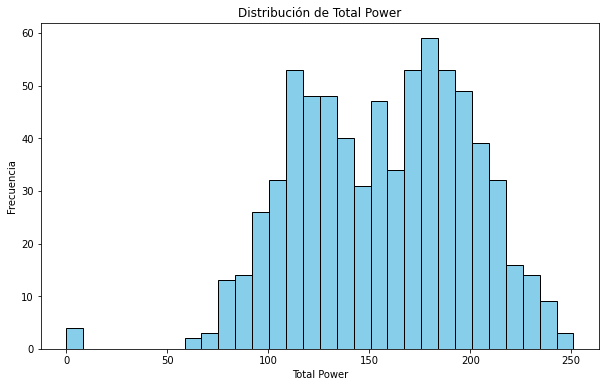

In [0]:
import matplotlib.pyplot as plt  # Asegúrate de importar matplotlib

# Convertir el DataFrame de Spark a Pandas para poder graficarlo
df_pd = df_cleaned.toPandas()

# Graficar histograma de Total Power
plt.figure(figsize=(10, 6))
plt.hist(df_pd["Total_Power"], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Total Power')
plt.xlabel('Total Power')
plt.ylabel('Frecuencia')
plt.show()


#### Distribución de Pokémon según la relación CP/HP

Esta gráfica de dispersión muestra la relación entre el Attack/Defense Ratio y el Max CP de los Pokémon. El Attack/Defense Ratio es un indicador que mide la capacidad ofensiva de un Pokémon en comparación con su defensa, y el Max CP es el valor máximo de poder de combate que puede alcanzar un Pokémon.

La gráfica permite identificar tendencias y patrones en los datos, como si los Pokémon con un alto Attack/Defense Ratio tienden a tener un Max CP más alto, lo que podría indicar que aquellos con una mayor relación de ataque sobre defensa tienen un mayor potencial de poder de combate. Además, esta visualización puede ayudar a los jugadores a evaluar la estrategia de mejorar Pokémon que se especializan en ataque frente a aquellos que tienen un balance entre defensa y ataque.

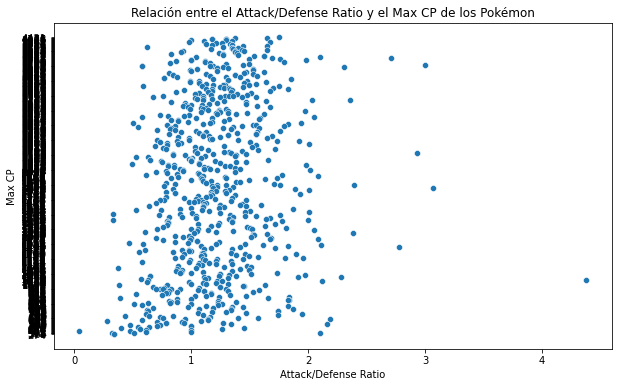

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir el DataFrame a Pandas para graficar
df_cleaned_pd = df_cleaned.toPandas()

# Crear la gráfica
plt.figure(figsize=(10,6))
sns.scatterplot(x="Attack_Defense_Ratio", y="Max CP", data=df_cleaned_pd)
plt.title("Relación entre el Attack/Defense Ratio y el Max CP de los Pokémon")
plt.xlabel("Attack/Defense Ratio")
plt.ylabel("Max CP")
plt.show()



#### Distribución de Pokémon según Attack y Defense
Esta gráfica de dispersión visualiza la relación entre las estadísticas de Attack (Ataque) y Defense (Defensa) de los Pokémon. Cada punto en la gráfica representa un Pokémon, con su valor de ataque en el eje X y su valor de defensa en el eje Y.

El análisis de esta gráfica es útil para identificar cómo se distribuyen los Pokémon en cuanto a estas dos características clave, y si existe alguna tendencia o patrón entre los valores de ataque y defensa. Por ejemplo, se podría observar si los Pokémon más fuertes en ataque también tienen una defensa proporcionalmente alta, o si existe una disparidad entre estos dos atributos. Esto puede ser valioso para entender la estrategia de lucha en Pokémon Go, donde los jugadores deben balancear sus Pokémon entre ataque y defensa para obtener el mejor rendimiento en combate.

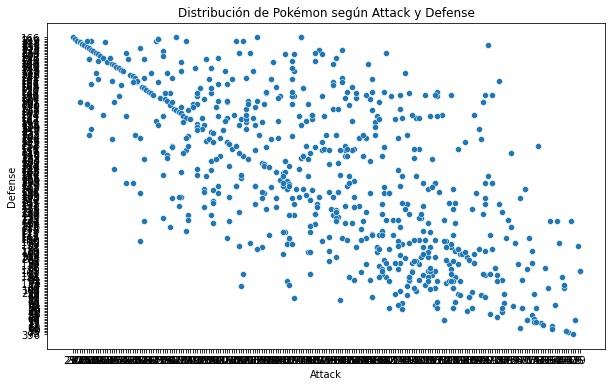

In [0]:
# Convertir el DataFrame a Pandas para graficar
df_cleaned_pd = df_cleaned.toPandas()

# Crear la gráfica de dispersión
plt.figure(figsize=(10,6))
sns.scatterplot(x="Attack", y="Defense", data=df_cleaned_pd)
plt.title("Distribución de Pokémon según Attack y Defense")
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.show()

#### Distribución de Attack vs Defense por Tipo de Pokémon
En esta gráfica de hexbin, se muestran las relaciones entre Attack y Defense para los Pokémon, con la diferencia de que los valores de Total Stats de cada Pokémon se representan por la coloración de los hexágonos. Esta gráfica permite observar cómo se agrupan los Pokémon según su tipo, mostrando posibles patrones entre ataque y defensa. Además, al usar un mapa de calor, se puede identificar fácilmente los grupos de Pokémon con mayores o menores estadísticas totales, ayudando a visualizar la fuerza global de los Pokémon en función de estos dos atributos clave.

<command-1491102002833043>:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="Total Stats")


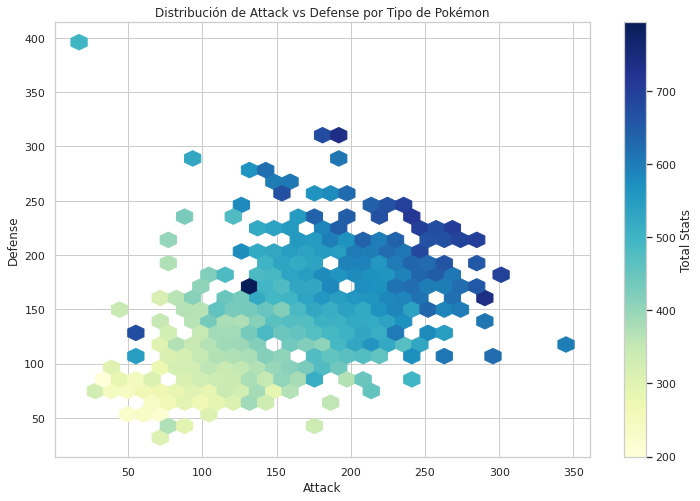

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convertir el DataFrame a Pandas para graficar
df_cleaned_pd = df_cleaned.toPandas()

# Asegurarse de que las columnas sean numéricas
df_cleaned_pd["Attack"] = pd.to_numeric(df_cleaned_pd["Attack"], errors='coerce')
df_cleaned_pd["Defense"] = pd.to_numeric(df_cleaned_pd["Defense"], errors='coerce')
df_cleaned_pd["Total Stats"] = pd.to_numeric(df_cleaned_pd["Total Stats"], errors='coerce')

# Eliminar filas con NaN en las columnas relevantes para evitar problemas
df_cleaned_pd = df_cleaned_pd.dropna(subset=["Attack", "Defense", "Total Stats"])

# Establecer estilo Seaborn
sns.set(style="whitegrid")

# Gráfica Hexbin para los tipos de Pokémon (con matplotlib)
plt.figure(figsize=(12,8))
plt.hexbin(df_cleaned_pd["Attack"], df_cleaned_pd["Defense"], C=df_cleaned_pd["Total Stats"], gridsize=30, cmap="YlGnBu", reduce_C_function=np.mean)
plt.colorbar(label="Total Stats")
plt.title("Distribución de Attack vs Defense por Tipo de Pokémon")
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.show()


#### Distribución de Attack vs Defense para cada Pokémon

En esta gráfica de hexbin, se muestran los atributos Attack y Defense de los Pokémon, pero con un enfoque adicional: el valor de Max CP (poder de combate máximo) se usa para colorear los hexágonos. Esto permite observar cómo se distribuyen los Pokémon según su poder de combate, destacando las diferencias entre Pokémon con ataques y defensas altas o bajas. Este tipo de gráfico es útil para ver si hay alguna correlación entre el poder de combate y la distribución de estos dos atributos clave.


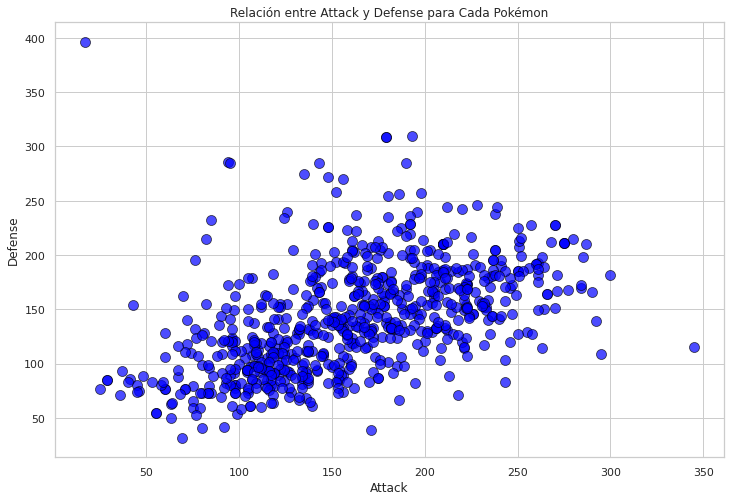

In [0]:
# Gráfica de dispersión por Pokémon individualmente
plt.figure(figsize=(12, 8))
sns.scatterplot(x="Attack", y="Defense", data=df_cleaned_pd, s=100, color='blue', alpha=0.7, edgecolor="black")
plt.title("Relación entre Attack y Defense para Cada Pokémon")
plt.xlabel("Attack")
plt.ylabel("Defense")
plt.show()



#### Comparando Legendarios

Primero, separamos los Pokémon en dos grupos: legendarios y no legendarios:

In [0]:
import pandas as pd

# Separar Pokémon legendarios y no legendarios
legendary_df = df_cleaned.filter(df_cleaned["Is Legendary"] == True).toPandas()
non_legendary_df = df_cleaned.filter(df_cleaned["Is Legendary"] == False).toPandas()


Ahora calculamos las estadísticas promedio para los dos grupos (legendarios y no legendarios) en las mismas categorías:

In [0]:
# Seleccionar las columnas relevantes
stats_columns = ["Attack", "Defense", "Stamina", "Max CP", "Max HP"]

# Calcular las estadísticas promedio de los legendarios y no legendarios
legendary_avg_stats = legendary_df[stats_columns].mean()
non_legendary_avg_stats = non_legendary_df[stats_columns].mean()


Para comparar ambos grupos de manera justa, es importante normalizar las estadísticas (es decir, ponerlas en la misma escala de 0 a 1). Usaremos los valores máximos en ambas categorías para normalizar:


In [0]:
from pyspark.sql import functions as F

# Calculamos el valor máximo de cada columna en el DataFrame
max_values = df_cleaned.select(
    F.max("Attack").alias("Attack"),
    F.max("Defense").alias("Defense"),
    F.max("Stamina").alias("Stamina"),
    F.max("Max CP").alias("Max_CP"),
    F.max("Max HP").alias("Max_HP")
).collect()[0]  # Esto nos da una fila con los valores máximos

# Convertir los valores máximos a un diccionario para facilitar su uso
max_values_dict = {key: max_values[key] for key in max_values.asDict()}

# Normalizar las estadísticas dividiendo por el valor máximo de cada columna
df_cleaned = df_cleaned.withColumn(
    "Normalized_Attack", F.round(F.col("Attack") / max_values_dict["Attack"], 2)
).withColumn(
    "Normalized_Defense", F.round(F.col("Defense") / max_values_dict["Defense"], 2)
).withColumn(
    "Normalized_Stamina", F.round(F.col("Stamina") / max_values_dict["Stamina"], 2)
).withColumn(
    "Normalized_Max_CP", F.round(F.col("Max CP") / max_values_dict["Max_CP"], 2)
).withColumn(
    "Normalized_Max_HP", F.round(F.col("Max HP") / max_values_dict["Max_HP"], 2)
)

df_cleaned.show(5)  # Mostrar el dataframe con las nuevas columnas normalizadas y redondeadas



+---------+------+------+------+-------+-------+-----------+------------+-------+------+-----------------+------------------+------------------+-----------------+-----------------+
|  Pokemon|Max CP|Max HP|Attack|Defense|Stamina|Total Stats|Is Legendary| Type 1|Type 2|Normalized_Attack|Normalized_Defense|Normalized_Stamina|Normalized_Max_CP|Normalized_Max_HP|
+---------+------+------+------+-------+-------+-----------+------------+-------+------+-----------------+------------------+------------------+-----------------+-----------------+
|  Slaking|  4431|   233|   290|    166|    284|        740|       False| normal|  none|             2.93|              1.68|              2.87|             4.46|             2.38|
|Regigigas|  4346|   184|   287|    210|    221|        718|        True| normal|  none|              2.9|              2.12|              2.23|             4.38|             1.88|
|   Mewtwo|  4178|   179|   300|    182|    214|        696|        True|psychic|  none|       

Para crear la gráfica, primero tenemos que asegurarnos de que nuestros datos estén listos para graficar. Después, usaremos seaborn o matplotlib para generar la gráfica de hexágonos, que es útil para ver la densidad de puntos en una comparación de varias características.

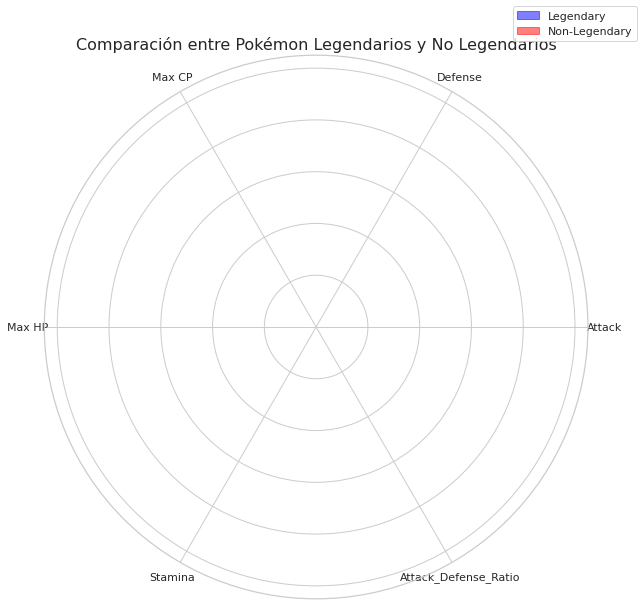

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Asegúrate de que el DataFrame esté listo
df_cleaned_pd = df_cleaned.toPandas()

# Definir las estadísticas clave
labels = ['Attack', 'Defense', 'Max CP', 'Max HP', 'Stamina', 'Attack_Defense_Ratio']

# Convertir las columnas a valores numéricos, forzando los errores a NaN
df_cleaned_pd[labels] = df_cleaned_pd[labels].apply(pd.to_numeric, errors='coerce')

# Rellenar los valores NaN con la media de cada columna
df_cleaned_pd[labels] = df_cleaned_pd[labels].fillna(df_cleaned_pd[labels].mean())

# Normalizar los valores para una mejor visualización
df_cleaned_pd[labels] = df_cleaned_pd[labels].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Filtrar Pokémon legendarios y no legendarios
legendary_avg = df_cleaned_pd[df_cleaned_pd['Is Legendary'] == True][labels].mean()
non_legendary_avg = df_cleaned_pd[df_cleaned_pd['Is Legendary'] == False][labels].mean()

# Convertir las medias en listas
legendary_values = legendary_avg.tolist()
non_legendary_values = non_legendary_avg.tolist()

# Añadir el primer valor al final para cerrar el círculo
legendary_values.append(legendary_values[0])
non_legendary_values.append(non_legendary_values[0])

# Número de variables (ahora hay 6 estadísticas)
num_vars = len(labels)

# Ángulos de las variables (hay que hacer un ajuste aquí)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Añadir el primer ángulo al final para cerrar el círculo
angles += angles[:1]

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))  # Tamaño de gráfico más grande

# Rellenar con colores para Pokémon legendarios y no legendarios
ax.fill(angles, legendary_values, color='blue', alpha=0.5, label='Legendary')  # Aseguramos un alpha visible
ax.fill(angles, non_legendary_values, color='red', alpha=0.5, label='Non-Legendary')  # Aseguramos un alpha visible

# Graficar las líneas
ax.plot(angles, legendary_values, color='blue', linewidth=2, linestyle='solid')
ax.plot(angles, non_legendary_values, color='red', linewidth=2, linestyle='solid')

# Etiquetas y títulos
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Título
plt.title('Comparación entre Pokémon Legendarios y No Legendarios', size=16)

# Leyenda
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Mostrar la gráfica
plt.show()

